In [1]:
import pandas as pd
df = pd.read_csv('Fraud_Data.csv')
country = pd.read_csv('IpAddress_to_Country.csv')
country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [2]:
country.shape

(138846, 3)

In [4]:
country.describe()

,lower_bound_ip_address,upper_bound_ip_address
count,1.388460e+05,1.388460e+05
mean,2.724532e+09,2.724557e+09
std,8.975215e+08,8.974979e+08
min,1.677722e+07,1.677747e+07
25%,1.919930e+09,1.920008e+09
50%,3.230887e+09,3.230888e+09
75%,3.350465e+09,3.350466e+09
max,3.758096e+09,3.758096e+09


In [5]:
df.shape

(151112, 11)

In [6]:
df.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [73]:
L=[]
for i in range(df.shape[0]):
    L.append('-1')
df['country'] = L
d={}
for index, row in country.iterrows():
    d[row['lower_bound_ip_address']] = row['country']
ip = sorted(d.keys())

for index, row in df.iterrows():
    if index%1000==0:
        print(index)

    target = row['ip_address']
    l = 0
    h = len(ip)
    while l!=len(ip)-1 and l<=h:
        m = int((l+h)/2)
        if ip[m]<=target and ip[m+1]>target:
            break
        elif ip[m]>target:
            h = m-1
        elif ip[m+1]<=target:
            l = m+1
    if l==len(ip)-1:
        m = l
    df.at[index,'country'] = d[ip[m]]

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000


In [96]:
L=[]
for i in range(df.shape[0]):
    L.append(-1)
df['device_repete'] = L
l = df['device_id'].tolist()
for index, row in df.iterrows():
    df.at[index, 'device_repete'] = l.count(row['device_id'])

In [106]:

from datetime import datetime
L=[]
for i in range(df.shape[0]):
    L.append(-1)
df['duration'] = L
df['signuphour'] = L
df['purchasehour'] = L

for index, row in df.iterrows():
    df.at[index, 'duration'] = (datetime.strptime(row['purchase_time'], '%Y-%m-%d %H:%M:%S') - datetime.strptime(row['signup_time'], '%Y-%m-%d %H:%M:%S')).seconds
    df.at[index, 'signuphour'] = datetime.strptime(row['signup_time'], '%Y-%m-%d %H:%M:%S').hour
    df.at[index, 'purchansehour'] = datetime.strptime(row['purchase_time'], '%Y-%m-%d %H:%M:%S').hour
    

In [130]:
#df = df.drop(['purchasehour'], axis =1)
df = df.rename(columns={'purchansehour': 'purchasehour'})

In [179]:
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.model import H2OBinomialModel
h2o.init()
from __future__ import print_function
import sklearn
import sklearn.datasets
import sklearn.ensemble
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import numpy as np
class h2o_predict_proba_wrapper:
    # drf is the h2o distributed random forest object, the column_names is the
    # labels of the X values
    def __init__(self,model,column_names):
            
            self.model = model
            self.column_names = column_names
 
    def predict_proba(self,this_array):        
        # If we have just 1 row of data we need to reshape it
        shape_tuple = np.shape(this_array)        
        if len(shape_tuple) == 1:
            this_array = this_array.reshape(1, -1)
            
        # We convert the numpy array that Lime sends to a pandas dataframe and
        # convert the pandas dataframe to an h2o frame
        self.pandas_df = pd.DataFrame(data = this_array,columns = self.column_names)
        self.h2o_df = h2o.H2OFrame(self.pandas_df)
        
        # Predict with the h2o drf
        self.predictions = self.model.predict(self.h2o_df).as_data_frame()
        # the first column is the class labels, the rest are probabilities for
        # each class
        self.predictions = self.predictions.iloc[:,1:].as_matrix()
        return self.predictions

l = [3,5,6,7,8,10,11,12,13,14,15]
d = df.iloc[:,l]

feature_names = ['purchase_value','source', 'browser','sex','age','country','device_repete','duration','signuphour','purchasehour'] 

class_names = 'class'

labels = np.array(d.iloc[:,5])
le= sklearn.preprocessing.LabelEncoder()
le.fit(labels)
labels = le.transform(labels)
class_names = le.classes_

datacolumn=[0,1,2,3,4,6,7,8,9,10]
data = np.array(d.iloc[:,datacolumn]) # no label no name for column
categorical_features = [1,2,3,5]
categorical_names = ['source', 'browser','sex', 'country'  ]
categorical_names = {}
for feature in categorical_features:
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(data[:, feature])
    data[:, feature] = le.transform(data[:, feature])
    categorical_names[feature] = le.classes_


encoder = sklearn.preprocessing.OneHotEncoder(categorical_features=categorical_features)



train, test, labels_train, labels_test = train_test_split(data, labels, train_size=0.70)


train_h2o_df = h2o.H2OFrame(train)
train_h2o_df.set_names(feature_names)
train_h2o_df['class'] = h2o.H2OFrame(labels_train).asfactor()


test_h2o_df = h2o.H2OFrame(test)
test_h2o_df.set_names(feature_names)
test_h2o_df['calss'] = h2o.H2OFrame(labels_test).asfactor()



for feature in categorical_features:
    train_h2o_df[feature] = train_h2o_df[feature].asfactor()
    test_h2o_df[feature] = test_h2o_df[feature].asfactor()
    

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,5 days 21 hours 40 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.11
H2O cluster version age:,2 months and 28 days
H2O cluster name:,H2O_from_python_yiyuanfeng_00ami5
H2O cluster total nodes:,1
H2O cluster free memory:,1.418 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [186]:
fraud_drf = H2ORandomForestEstimator(
        model_id="class",
        ntrees=100,
        #stopping_rounds=2,
        score_each_iteration=True,
        #seed=1000000,
        nfolds=5,
        balance_classes=False,
        histogram_type="AUTO")

fraud_drf.train(x=feature_names,
         y='class',
         training_frame=train_h2o_df)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [198]:
fraud_drf.coef_norm

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  class


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.039928649324244794
RMSE: 0.1998215436939791
LogLoss: 0.17659759229102964
Mean Per-Class Error: 0.18645125683509556
AUC: 0.844281624204066
Gini: 0.6885632484081321
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.75: 


,0,1,Error,Rate
0,95930.0,1.0,0.0,(1.0/95931.0)
1,4572.0,5275.0,0.4643,(4572.0/9847.0)
Total,100502.0,5276.0,0.0432,(4573.0/105778.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.75,0.6976129,17.0
max f2,0.1521184,0.6506409,186.0
max f0point5,0.8054167,0.8522121,16.0
max accuracy,0.8054167,0.9567679,16.0
max precision,0.9999992,1.0,0.0
max recall,0.0000560,1.0,399.0
max specificity,0.9999992,1.0,0.0
max absolute_mcc,0.8054167,0.7149998,16.0
max min_per_class_accuracy,0.0522143,0.7637859,281.0
max mean_per_class_accuracy,0.1234975,0.8135487,205.0


Gains/Lift Table: Avg response rate:  9.31 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0470797,1.0,10.7421550,10.7421550,1.0,1.0,0.5057378,0.5057378,974.2154971,974.2154971
,2,0.0500009,0.6564019,10.3249839,10.7177825,0.9611650,0.9977311,0.0301615,0.5358993,932.4983904,971.7782526
,3,0.1000019,0.1793978,2.4230272,6.5704049,0.2255625,0.6116468,0.1211537,0.6570529,142.3027204,557.0404865
,4,0.1500028,0.0993327,1.0926979,4.7445026,0.1017206,0.4416714,0.0546359,0.7116888,9.2697934,374.4502555
,5,0.2000038,0.0721893,0.4244867,3.6644986,0.0395160,0.3411325,0.0212247,0.7329136,-57.5513256,266.4498602
,6,0.3000057,0.0493349,0.3605091,2.5631688,0.0335602,0.2386084,0.0360516,0.7689652,-63.9490923,156.3168760
,7,0.3999981,0.0374007,0.3625744,2.0130592,0.0337525,0.1873981,0.0362547,0.8052199,-63.7425610,101.3059175
,8,0.5,0.0295374,0.3625401,1.6829491,0.0337493,0.1566677,0.0362547,0.8414746,-63.7459886,68.2949122
,9,0.6000019,0.0235426,0.3351211,1.4583076,0.0311968,0.1357556,0.0335127,0.8749873,-66.4878886,45.8307581
,10,0.6999943,0.0184054,0.3442933,1.2991734,0.0320507,0.1209416,0.0344267,0.9094140,-65.5706672,29.9173434




ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.03966226420626684
RMSE: 0.19915387067859575
LogLoss: 0.16753681804535514
Mean Per-Class Error: 0.18344643291814888
AUC: 0.8415888803629282
Gini: 0.6831777607258565
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.7788888889551162: 


,0,1,Error,Rate
0,95931.0,0.0,0.0,(0.0/95931.0)
1,4571.0,5276.0,0.4642,(4571.0/9847.0)
Total,100502.0,5276.0,0.0432,(4571.0/105778.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.7788889,0.6977452,16.0
max f2,0.1432547,0.6560424,191.0
max f0point5,0.7788889,0.8523149,16.0
max accuracy,0.7788889,0.9567869,16.0
max precision,0.9999970,1.0,0.0
max recall,0.0001838,1.0,399.0
max specificity,0.9999970,1.0,0.0
max absolute_mcc,0.7788889,0.7151425,16.0
max min_per_class_accuracy,0.0499845,0.7665279,285.0
max mean_per_class_accuracy,0.1070717,0.8165536,217.0


Gains/Lift Table: Avg response rate:  9.31 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0436007,1.0,10.7421550,10.7421550,1.0,1.0,0.4683660,0.4683660,974.2154971,974.2154971
,2,0.0500009,0.6315687,10.5358802,10.7157515,0.9807976,0.9975421,0.0674317,0.5357977,953.5880208,971.5751489
,3,0.1000019,0.1792395,2.4392755,6.5775135,0.2270751,0.6123086,0.1219661,0.6577638,143.9275500,557.7513495
,4,0.1500028,0.0919407,1.2023739,4.7858003,0.1119304,0.4455159,0.0601198,0.7178836,20.2373935,378.5800308
,5,0.2000038,0.0662901,0.3818350,3.6848090,0.0355455,0.3430233,0.0190921,0.7369757,-61.8165034,268.4808973
,6,0.3000057,0.0470989,0.3452763,2.5716314,0.0321422,0.2393962,0.0345283,0.7715040,-65.4723701,157.1631415
,7,0.3999981,0.0374671,0.3189030,2.0084892,0.0296871,0.1869727,0.0318879,0.8033919,-68.1097035,100.8489234
,8,0.5,0.0310851,0.3280125,1.6723875,0.0305351,0.1556845,0.0328019,0.8361938,-67.1987516,67.2387529
,9,0.6000019,0.0259382,0.3148107,1.4461212,0.0293061,0.1346211,0.0314817,0.8676754,-68.5189257,44.6121166
,10,0.6999943,0.0215066,0.3209342,1.2853910,0.0298761,0.1196586,0.0320910,0.8997664,-67.9065806,28.5391025



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.9567054,0.0012590,0.9546837,0.9545562,0.9572503,0.9588868,0.9581503
auc,0.8418569,0.0071373,0.8391187,0.8256838,0.8417299,0.8459401,0.8568121
err,0.0432946,0.0012590,0.0453164,0.0454438,0.0427497,0.0411132,0.0418497
err_count,915.8,24.804838,954.0,962.0,898.0,879.0,886.0
f0point5,0.8501133,0.0060067,0.8422522,0.8376963,0.8575282,0.8584313,0.8546588
f1,0.6983013,0.0071227,0.6948177,0.6803986,0.7065359,0.7080704,0.7016835
f2,0.5925179,0.0075099,0.59131,0.5728351,0.6007558,0.6025322,0.5951565
lift_top_group,10.74551,0.1536160,10.426944,10.713057,10.614451,10.992288,10.980809
logloss,0.1675587,0.0043869,0.1732743,0.1751011,0.1685692,0.1606195,0.1602294
max_per_class_error,0.4618255,0.0075264,0.4621099,0.4817814,0.4537645,0.4519280,0.4595436


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error
,2018-08-21 16:11:35,7 min 32.240 sec,0.0,nan,nan,nan,nan,nan
,2018-08-21 16:11:35,7 min 32.330 sec,1.0,0.2460875,1.6082051,0.7681605,7.6027899,0.0601424
,2018-08-21 16:11:35,7 min 32.422 sec,2.0,0.2463204,1.5068955,0.7791361,7.9099347,0.0590920
,2018-08-21 16:11:35,7 min 32.529 sec,3.0,0.2413134,1.3511578,0.7816251,8.3678116,0.0554860
,2018-08-21 16:11:35,7 min 32.655 sec,4.0,0.2348778,1.1568502,0.7901793,8.8614521,0.0518309
---,---,---,---,---,---,---,---,---
,2018-08-21 16:11:46,7 min 44.148 sec,96.0,0.1998580,0.1768140,0.8441883,10.7421550,0.0432321
,2018-08-21 16:11:47,7 min 44.261 sec,97.0,0.1998372,0.1767543,0.8441964,10.7421550,0.0432321
,2018-08-21 16:11:47,7 min 44.383 sec,98.0,0.1998202,0.1766311,0.8444198,10.7421550,0.0432321
,2018-08-21 16:11:47,7 min 44.498 sec,99.0,0.1998134,0.1766336,0.8442847,10.7421550,0.0432321



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
duration,206126.0468750,1.0,0.3936924
device_repete,193136.9531250,0.9369847,0.3688837
country,29385.8242188,0.1425624,0.0561257
purchase_value,22082.1132812,0.1071292,0.0421759
age,20578.8164062,0.0998361,0.0393047
purchasehour,17530.3066406,0.0850465,0.0334822
signuphour,16042.3515625,0.0778279,0.0306402
browser,9029.3496094,0.0438050,0.0172457
source,5439.4619141,0.0263890,0.0103892
sex,4220.1484375,0.0204736,0.0080603


<bound method ModelBase.coef_norm of >

In [128]:
import pandas as pd
df = pd.read_csv('first_version.csv')
df = df.drop('Unnamed: 0', axis = 1)
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,device_repete,duration,signuphour,purchansehour
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,13882,22,2.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,17944,20,1.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,1,18,18.0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Australia,1,60085,21,13.0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1,41461,7,18.0


In [181]:
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator, H2ODeepLearningEstimator
# dl = H2OAutoEncoderEstimator( 
#         activation="Tanh", 
#         hidden=[50], 
#         l1=1e-5,
#         score_interval=0,
#         epochs=100
# )

dl = H2ODeepLearningEstimator(
  epochs=50,
  nfolds=5 
  )
dl.train(x=feature_names,y='class', training_frame=train_h2o_df)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [182]:
prediction = dl.predict(test_h2o_df)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/Users/yiyuanfeng/anaconda/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'country' has levels not trained on: [33, 49, 58, 62, 142, 174, 178]
  warnings.warn(w)


In [165]:
rf_pre = fraud_drf.predict(test_h2o_df)

drf prediction progress: |████████████████████████████████████████████████| 100%


/Users/yiyuanfeng/anaconda/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'country' has levels not trained on: [Benin, Bhutan, Djibouti, Niger, Reunion, Saint Martin]
  warnings.warn(w)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(predictors.values, outcome.values.ravel())

importance = clf.feature_importances_
importance = pd.DataFrame(importance, index=predictors.columns, 
                          columns=["Importance"])

importance["Std"] = np.std([tree.feature_importances_
                            for tree in clf.estimators_], axis=0)

x = range(importance.shape[0])
y = importance.ix[:, 0]
yerr = importance.ix[:, 1]

plt.bar(x, y, yerr=yerr, align="center")

plt.show()

In [184]:
dl.coef_norm

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1534369786457_204


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.03572113836874043
RMSE: 0.18900036605451437
LogLoss: 0.1480618713763002
Mean Per-Class Error: 0.16966353506663756
AUC: 0.8862122521872121
Gini: 0.7724245043744242
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37044974744264825: 


,0,1,Error,Rate
0,9091.0,63.0,0.0069,(63.0/9154.0)
1,352.0,568.0,0.3826,(352.0/920.0)
Total,9443.0,631.0,0.0412,(415.0/10074.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3704497,0.7324307,84.0
max f2,0.1715852,0.6831490,168.0
max f0point5,0.5555901,0.8597798,42.0
max accuracy,0.5243881,0.9604924,46.0
max precision,0.9999266,1.0,0.0
max recall,0.0004587,1.0,398.0
max specificity,0.9999266,1.0,0.0
max absolute_mcc,0.5243881,0.7367900,46.0
max min_per_class_accuracy,0.0402809,0.7989130,280.0
max mean_per_class_accuracy,0.0838926,0.8303365,219.0


Gains/Lift Table: Avg response rate:  9.13 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0102243,0.9999102,10.9500000,10.9500000,1.0,1.0,0.1119565,0.1119565,995.0000000,995.0000000
,2,0.0200516,0.9997188,10.9500000,10.9500000,1.0,1.0,0.1076087,0.2195652,995.0000000,995.0000000
,3,0.0300774,0.9991411,10.9500000,10.9500000,1.0,1.0,0.1097826,0.3293478,995.0000000,995.0000000
,4,0.0400040,0.9978733,10.9500000,10.9500000,1.0,1.0,0.1086957,0.4380435,995.0000000,995.0000000
,5,0.0500298,0.9804481,10.7331683,10.9065476,0.9801980,0.9960317,0.1076087,0.5456522,973.3168317,990.6547619
,6,0.1000596,0.1427435,2.9764881,6.9415179,0.2718254,0.6339286,0.1489130,0.6945652,197.6488095,594.1517857
,7,0.1499901,0.0600620,0.8707753,4.9206155,0.0795229,0.4493713,0.0434783,0.7380435,-12.9224652,392.0615486
,8,0.2000199,0.0468166,0.6952381,3.8637469,0.0634921,0.3528536,0.0347826,0.7728261,-30.4761905,286.3746898
,9,0.2999801,0.0358096,0.4349553,2.7211946,0.0397219,0.2485109,0.0434783,0.8163043,-56.5044687,172.1194573
,10,0.4000397,0.0293602,0.4019345,2.1410918,0.0367063,0.1955335,0.0402174,0.8565217,-59.8065476,114.1091811




ModelMetricsBinomial: deeplearning
** Reported on cross-validation data. **

MSE: 0.03994359336118947
RMSE: 0.1998589336536885
LogLoss: 0.17069003496189217
Mean Per-Class Error: 0.18039560275287014
AUC: 0.839079193413826
Gini: 0.678158386827652
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6955743255711679: 


,0,1,Error,Rate
0,95862.0,69.0,0.0007,(69.0/95931.0)
1,4561.0,5286.0,0.4632,(4561.0/9847.0)
Total,100423.0,5355.0,0.0438,(4630.0/105778.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.6955743,0.6954348,58.0
max f2,0.0926984,0.6609549,246.0
max f0point5,0.8780517,0.8460894,42.0
max accuracy,0.7779614,0.9562291,52.0
max precision,0.9981616,0.9975681,3.0
max recall,0.0003024,1.0,399.0
max specificity,0.9999253,0.9999583,0.0
max absolute_mcc,0.7779614,0.7105591,52.0
max min_per_class_accuracy,0.0369732,0.7601714,310.0
max mean_per_class_accuracy,0.0806589,0.8196044,253.0


Gains/Lift Table: Avg response rate:  9.31 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100021,0.9993649,10.6913886,10.6913886,0.9952741,0.9952741,0.1069361,0.1069361,969.1388643,969.1388643
,2,0.0200136,0.9976384,10.7421550,10.7167838,1.0,0.9976382,0.1075454,0.2144816,974.2154971,971.6783797
,3,0.0300062,0.9943085,10.6811777,10.7049263,0.9943236,0.9965343,0.1067330,0.3212146,968.1177743,970.4926331
,4,0.0400178,0.9869961,10.6812929,10.6990138,0.9943343,0.9959839,0.1069361,0.4281507,968.1292903,969.9013786
,5,0.0500009,0.8952944,10.4674976,10.6527893,0.9744318,0.9916808,0.1044988,0.5326495,946.7497600,965.2789341
,6,0.1000019,0.1615436,2.5347342,6.5937618,0.2359614,0.6138211,0.1267391,0.6593886,153.4734242,559.3761791
,7,0.1500028,0.0585848,1.1069152,4.7648129,0.1030441,0.4435621,0.0553468,0.7147355,10.6915194,376.4812925
,8,0.2000038,0.0463201,0.3249659,3.6548512,0.0302515,0.3402344,0.0162486,0.7309841,-67.5034072,265.4851176
,9,0.3000057,0.0357901,0.3483229,2.5526751,0.0324258,0.2376316,0.0348329,0.7658170,-65.1677145,155.2675069
,10,0.3999981,0.0296885,0.3534339,2.0029038,0.0329016,0.1864527,0.0353407,0.8011577,-64.6566141,100.2903750



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.9560994,0.0011157,0.9563864,0.9577411,0.9533755,0.9574806,0.9555133
auc,0.8408512,0.0020247,0.8450261,0.8426437,0.8370249,0.8410879,0.8384733
err,0.0439006,0.0011157,0.0436136,0.0422589,0.0466245,0.0425194,0.0444867
err_count,928.6,20.964733,925.0,892.0,980.0,910.0,936.0
f0point5,0.8418284,0.0081313,0.8459166,0.8516306,0.8192543,0.8469108,0.8454299
f1,0.6966879,0.0025448,0.6925889,0.7028648,0.6965944,0.6976744,0.6937173
f2,0.5943728,0.0050308,0.5863156,0.5983439,0.6058811,0.5931533,0.58817
lift_top_group,10.735254,0.1591635,10.826442,10.891641,10.366394,10.992296,10.599496
logloss,0.1707352,0.0080812,0.1634108,0.1652010,0.1932838,0.1633025,0.1684779
max_per_class_error,0.4585883,0.0064561,0.4680960,0.4556243,0.4425173,0.4607088,0.4659950


Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_auc,training_lift,training_classification_error
,2018-08-21 15:56:16,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan
,2018-08-21 15:56:21,25 min 34.598 sec,4867 obs/sec,0.2502600,1,26472.0,0.2027328,0.1917577,0.8290308,10.9500000,0.0428827
,2018-08-21 15:56:29,25 min 42.183 sec,6236 obs/sec,0.7519900,3,79544.0,0.1996512,0.1880455,0.8483888,10.9500000,0.0416915
,2018-08-21 15:56:35,25 min 47.845 sec,7318 obs/sec,1.2552137,5,132774.0,0.1989926,0.1707281,0.8477519,10.8415842,0.0418900
,2018-08-21 15:56:41,25 min 54.440 sec,8686 obs/sec,2.0087069,8,212477.0,0.1989348,0.1895087,0.8489760,10.9500000,0.0412944
---,---,---,---,---,---,---,---,---,---,---,---
,2018-08-21 15:59:21,28 min 33.788 sec,21021 obs/sec,34.9810452,139,3700225.0,0.1899999,0.1514610,0.8781571,10.9500000,0.0405003
,2018-08-21 15:59:27,28 min 39.760 sec,21099 obs/sec,36.2428199,144,3833693.0,0.1896240,0.1538790,0.8725029,10.9500000,0.0415922
,2018-08-21 15:59:32,28 min 45.557 sec,21185 obs/sec,37.4956513,149,3966215.0,0.1937417,0.1555218,0.8782222,10.9500000,0.0420885
,2018-08-21 15:59:38,28 min 51.470 sec,21255 obs/sec,38.7524249,154,4099154.0,0.1900504,0.1556559,0.8774611,10.9500000,0.0411952



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
device_repete,1.0,1.0,0.0225317
duration,0.9990366,0.9990366,0.0225100
purchasehour,0.9161136,0.9161136,0.0206416
signuphour,0.8931779,0.8931779,0.0201248
sex.1,0.4257110,0.4257110,0.0095920
---,---,---,---
country.11,0.1666473,0.1666473,0.0037548
country.missing(NA),0.0,0.0,0.0
browser.missing(NA),0.0,0.0,0.0
source.missing(NA),0.0,0.0,0.0



See the whole table with table.as_data_frame()


<bound method ModelBase.coef_norm of >

Could not find exact threshold 0.02; using closest threshold found 0.0200991658258684.
Could not find exact threshold 0.02; using closest threshold found 0.0200991658258684.
Could not find exact threshold 0.04; using closest threshold found 0.03992568464399733.
Could not find exact threshold 0.04; using closest threshold found 0.03992568464399733.
Could not find exact threshold 0.06; using closest threshold found 0.06013631998195542.
Could not find exact threshold 0.06; using closest threshold found 0.06013631998195542.
Could not find exact threshold 0.08; using closest threshold found 0.08019823633306204.
Could not find exact threshold 0.08; using closest threshold found 0.08019823633306204.
Could not find exact threshold 0.1; using closest threshold found 0.10000519977868409.
Could not find exact threshold 0.1; using closest threshold found 0.10000519977868409.
Could not find exact threshold 0.12; using closest threshold found 0.1200851829764262.
Could not find exact threshold 0.12; 

Could not find exact threshold 0.96; using closest threshold found 0.9622507122507122.
Could not find exact threshold 0.96; using closest threshold found 0.9622507122507122.
Could not find exact threshold 0.98; using closest threshold found 0.9822858014465814.
Could not find exact threshold 0.98; using closest threshold found 0.9822858014465814.


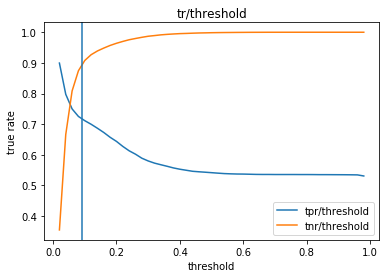

In [247]:
pr=[]
nr=[]
for i in range (1,50):
    pr.append(fraud_drf.sensitivity(thresholds=[i*0.02])[0][1])
    nr.append(fraud_drf.specificity(thresholds=[i*0.02])[0][1])
import matplotlib.pyplot as plt
X = range (1,50)
x=[]
for i in X:
    i = i*0.02
    x.append(i)
y1 = pr
y2 = nr
plt.plot(x, y1, label = "tpr/threshold")
plt.plot(x, y2, label = "tnr/threshold")
plt.axvline(0.09)
plt.xlabel('threshold')
plt.ylabel('true rate')
plt.title('tr/threshold')

plt.legend()

plt.show()

In [252]:
df[df['class']==1].shape

(14151, 16)

In [275]:
import numpy as np

index = df[df['class']==0].index.tolist()
newindex = np.random.choice(index, 70755)

In [276]:
positiveindex = np.array(df[df['class']==1].index)
twoclassindex = np.concatenate((positiveindex,newindex), axis=0).tolist()

In [277]:
l = [3,5,6,7,8,10,11,12,13,14,15]
d = df.iloc[twoclassindex,l]

feature_names = ['purchase_value','source', 'browser','sex','age','country','device_repete','duration','signuphour','purchasehour'] 

class_names = 'class'

labels = np.array(d.iloc[:,5])
le= sklearn.preprocessing.LabelEncoder()
le.fit(labels)
labels = le.transform(labels)
class_names = le.classes_

datacolumn=[0,1,2,3,4,6,7,8,9,10]
data = np.array(d.iloc[:,datacolumn]) # no label no name for column
categorical_features = [1,2,3,5]
categorical_names = ['source', 'browser','sex', 'country'  ]
categorical_names = {}
for feature in categorical_features:
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(data[:, feature])
    data[:, feature] = le.transform(data[:, feature])
    categorical_names[feature] = le.classes_


encoder = sklearn.preprocessing.OneHotEncoder(categorical_features=categorical_features)



train, test, labels_train, labels_test = train_test_split(data, labels, train_size=0.70)


train_h2o_df = h2o.H2OFrame(train)
train_h2o_df.set_names(feature_names)
train_h2o_df['class'] = h2o.H2OFrame(labels_train).asfactor()


test_h2o_df = h2o.H2OFrame(test)
test_h2o_df.set_names(feature_names)
test_h2o_df['calss'] = h2o.H2OFrame(labels_test).asfactor()



for feature in categorical_features:
    train_h2o_df[feature] = train_h2o_df[feature].asfactor()
    test_h2o_df[feature] = test_h2o_df[feature].asfactor()
    

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [278]:
fraud_drf = H2ORandomForestEstimator(
        model_id="class",
        ntrees=100,
        #stopping_rounds=2,
        score_each_iteration=True,
        #seed=1000000,
        nfolds=5,
        balance_classes=False,
        histogram_type="AUTO")

fraud_drf.train(x=feature_names,
         y='class',
         training_frame=train_h2o_df)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [279]:
fraud_drf.coef_norm

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  class


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.06313034816731161
RMSE: 0.2512575335533476
LogLoss: 0.24907451895864008
Mean Per-Class Error: 0.17598224220203806
AUC: 0.8596851470586505
Gini: 0.719370294117301
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33380953285529086: 


,0,1,Error,Rate
0,48260.0,1315.0,0.0265,(1315.0/49575.0)
1,3461.0,6398.0,0.351,(3461.0/9859.0)
Total,51721.0,7713.0,0.0804,(4776.0/59434.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3338095,0.7282040,137.0
max f2,0.2029179,0.7063099,191.0
max f0point5,0.7750124,0.8533727,24.0
max accuracy,0.6210623,0.9241343,47.0
max precision,1.0,1.0,0.0
max recall,0.0000723,1.0,399.0
max specificity,1.0,1.0,0.0
max absolute_mcc,0.6210623,0.7042321,47.0
max min_per_class_accuracy,0.0890934,0.7776651,270.0
max mean_per_class_accuracy,0.2162443,0.8240178,185.0


Gains/Lift Table: Avg response rate: 16.59 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0854561,1.0,6.0284004,6.0284004,1.0,1.0,0.5151638,0.5151638,502.8400446,502.8400446
,2,0.1000101,0.5115292,3.9027795,5.7190697,0.6473988,0.9486878,0.0568009,0.5719647,290.2779480,471.9069670
,3,0.1499983,0.2516542,2.3151817,4.5846949,0.3840458,0.7605160,0.1157318,0.6876965,131.5181726,358.4694899
,4,0.2000034,0.1436156,0.8012174,3.6387460,0.1329071,0.6036006,0.0400649,0.7277614,-19.8782579,263.8745958
,5,0.2999966,0.0923412,0.4280641,2.5685787,0.0710079,0.4260796,0.0428035,0.7705650,-57.1935893,156.8578698
,6,0.4000067,0.0717477,0.4269779,2.0331335,0.0708277,0.3372592,0.0427021,0.8132671,-57.3022108,103.3133456
,7,0.5,0.0583950,0.3824175,1.7030125,0.0634360,0.2824982,0.0382392,0.8515062,-61.7582539,70.3012476
,8,0.5999933,0.0483609,0.3550295,1.4783612,0.0588928,0.2452328,0.0355006,0.8870068,-64.4970527,47.8361242
,9,0.7000034,0.0395284,0.3002030,1.3100367,0.0497981,0.2173108,0.0300233,0.9170301,-69.9797017,31.0036738
,10,0.7999966,0.0309158,0.3012679,1.1839486,0.0499748,0.1963951,0.0301248,0.9471549,-69.8732133,18.3948585




ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.06316001236462049
RMSE: 0.2513165580788908
LogLoss: 0.237340027989742
Mean Per-Class Error: 0.17471929495856275
AUC: 0.8592385372020834
Gini: 0.7184770744041669
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37630916359393213: 


,0,1,Error,Rate
0,48587.0,988.0,0.0199,(988.0/49575.0)
1,3700.0,6159.0,0.3753,(3700.0/9859.0)
Total,52287.0,7147.0,0.0789,(4688.0/59434.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3763092,0.7243326,118.0
max f2,0.1927237,0.7086925,194.0
max f0point5,0.7698305,0.8529724,19.0
max accuracy,0.4986446,0.9241680,73.0
max precision,0.9999983,1.0,0.0
max recall,0.0002945,1.0,399.0
max specificity,0.9999983,1.0,0.0
max absolute_mcc,0.5790656,0.7038008,51.0
max min_per_class_accuracy,0.0874924,0.7742165,271.0
max mean_per_class_accuracy,0.2081511,0.8252807,188.0


Gains/Lift Table: Avg response rate: 16.59 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0821584,1.0,6.0284004,6.0284004,1.0,1.0,0.4952835,0.4952835,502.8400446,502.8400446
,2,0.1000101,0.5059017,4.3181756,5.7231265,0.7163054,0.9493607,0.0770869,0.5723704,331.8175626,472.3126467
,3,0.1499983,0.2547283,2.2928618,4.5799614,0.3803433,0.7597308,0.1146161,0.6869865,129.2861832,357.9961438
,4,0.2000034,0.1378114,0.7971606,3.6341817,0.1322342,0.6028434,0.0398621,0.7268486,-20.2839376,263.4181677
,5,0.2999966,0.0904113,0.4158917,2.5614785,0.0689887,0.4249019,0.0415864,0.7684349,-58.4108332,156.1478507
,6,0.4000067,0.0716316,0.4259637,2.0275549,0.0706595,0.3363338,0.0426007,0.8110356,-57.4036308,102.7554891
,7,0.5,0.0597672,0.3631444,1.6946952,0.0602389,0.2811186,0.0363120,0.8473476,-63.6855568,69.4695202
,8,0.5999933,0.0507208,0.3956043,1.4781922,0.0656234,0.2452047,0.0395578,0.8869054,-60.4395730,47.8192190
,9,0.7000034,0.0427824,0.3275864,1.3138041,0.0543405,0.2179358,0.0327619,0.9196673,-67.2413637,31.3804126
,10,0.7999966,0.0348130,0.3053253,1.1877522,0.0506478,0.1970261,0.0305305,0.9501978,-69.4674653,18.7752232



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.9189009,0.0038855,0.9137194,0.9229738,0.9109235,0.9222996,0.9245883
auc,0.8595437,0.0074422,0.854404,0.8572975,0.8450028,0.8645673,0.8764473
err,0.0810991,0.0038855,0.0862806,0.0770262,0.0890765,0.0777004,0.0754117
err_count,963.8,45.160603,1049.0,919.0,1034.0,915.0,902.0
f0point5,0.7833849,0.0200724,0.7517483,0.8198315,0.7489622,0.8043725,0.7920101
f1,0.7273634,0.0063280,0.7176312,0.7335460,0.7153084,0.7356256,0.7347059
f2,0.6795115,0.0059914,0.6864765,0.6636936,0.6845489,0.6777045,0.6851344
lift_top_group,6.0306168,0.0989781,6.085085,5.8860383,5.946721,5.9564996,6.27874
logloss,0.2374115,0.0075750,0.2398773,0.2414457,0.2519433,0.2346130,0.2191782
max_per_class_error,0.3487477,0.0112576,0.3328328,0.375925,0.3345287,0.3560951,0.3443569


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error
,2018-08-22 00:13:30,2 min 2.945 sec,0.0,nan,nan,nan,nan,nan
,2018-08-22 00:13:30,2 min 3.004 sec,1.0,0.3327368,3.4542393,0.7773406,4.2144459,0.1102373
,2018-08-22 00:13:30,2 min 3.057 sec,2.0,0.3169178,2.6937773,0.7864819,4.5723395,0.0998902
,2018-08-22 00:13:30,2 min 3.110 sec,3.0,0.3067328,2.2186321,0.7933692,4.8173727,0.0939966
,2018-08-22 00:13:30,2 min 3.175 sec,4.0,0.3001413,1.9236360,0.7995504,5.0387573,0.0915440
---,---,---,---,---,---,---,---,---
,2018-08-22 00:13:37,2 min 9.617 sec,96.0,0.2513437,0.2504502,0.8594261,6.0284004,0.0799038
,2018-08-22 00:13:37,2 min 9.680 sec,97.0,0.2513509,0.2503713,0.8593867,6.0284004,0.0798533
,2018-08-22 00:13:37,2 min 9.748 sec,98.0,0.2513130,0.2502549,0.8595371,6.0284004,0.0790457
,2018-08-22 00:13:37,2 min 9.812 sec,99.0,0.2512852,0.2501765,0.8594619,6.0284004,0.0789279



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
duration,211956.0312500,1.0,0.4174782
device_repete,172944.8750000,0.8159469,0.3406400
country,31113.9121094,0.1467942,0.0612834
purchase_value,21227.4921875,0.1001505,0.0418106
age,19604.7011719,0.0924942,0.0386143
purchasehour,16789.3945312,0.0792117,0.0330691
signuphour,15723.1035156,0.0741810,0.0309689
browser,9287.0380859,0.0438159,0.0182922
source,5011.8129883,0.0236455,0.0098715
sex,4047.3256836,0.0190951,0.0079718


<bound method ModelBase.coef_norm of >

Could not find exact threshold 0.02; using closest threshold found 0.020035806130085133.
Could not find exact threshold 0.02; using closest threshold found 0.020035806130085133.
Could not find exact threshold 0.04; using closest threshold found 0.03994990613763666.
Could not find exact threshold 0.04; using closest threshold found 0.03994990613763666.
Could not find exact threshold 0.06; using closest threshold found 0.06013492403373824.
Could not find exact threshold 0.06; using closest threshold found 0.06013492403373824.
Could not find exact threshold 0.08; using closest threshold found 0.07990051647070717.
Could not find exact threshold 0.08; using closest threshold found 0.07990051647070717.
Could not find exact threshold 0.1; using closest threshold found 0.09962341577518741.
Could not find exact threshold 0.1; using closest threshold found 0.09962341577518741.
Could not find exact threshold 0.12; using closest threshold found 0.12029576067617631.
Could not find exact threshold 0

Could not find exact threshold 0.9400000000000001; using closest threshold found 0.9379377048992795.
Could not find exact threshold 0.96; using closest threshold found 0.9626171129807777.
Could not find exact threshold 0.96; using closest threshold found 0.9626171129807777.
Could not find exact threshold 0.98; using closest threshold found 0.9806491861350738.
Could not find exact threshold 0.98; using closest threshold found 0.9806491861350738.


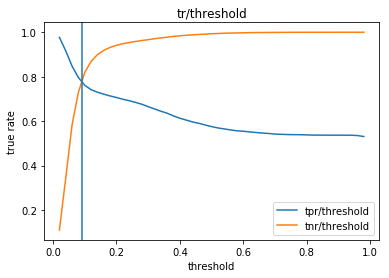

In [280]:
pr=[]
nr=[]
for i in range (1,50):
    pr.append(fraud_drf.sensitivity(thresholds=[i*0.02])[0][1])
    nr.append(fraud_drf.specificity(thresholds=[i*0.02])[0][1])
import matplotlib.pyplot as plt
X = range (1,50)
x=[]
for i in X:
    i = i*0.02
    x.append(i)
y1 = pr
y2 = nr
plt.plot(x, y1, label = "tpr/threshold")
plt.plot(x, y2, label = "tnr/threshold")
plt.axvline(0.09)
plt.xlabel('threshold')
plt.ylabel('true rate')
plt.title('tr/threshold')

plt.legend()

plt.show()

In [274]:
d[d['class']==1].shape

(14151, 11)

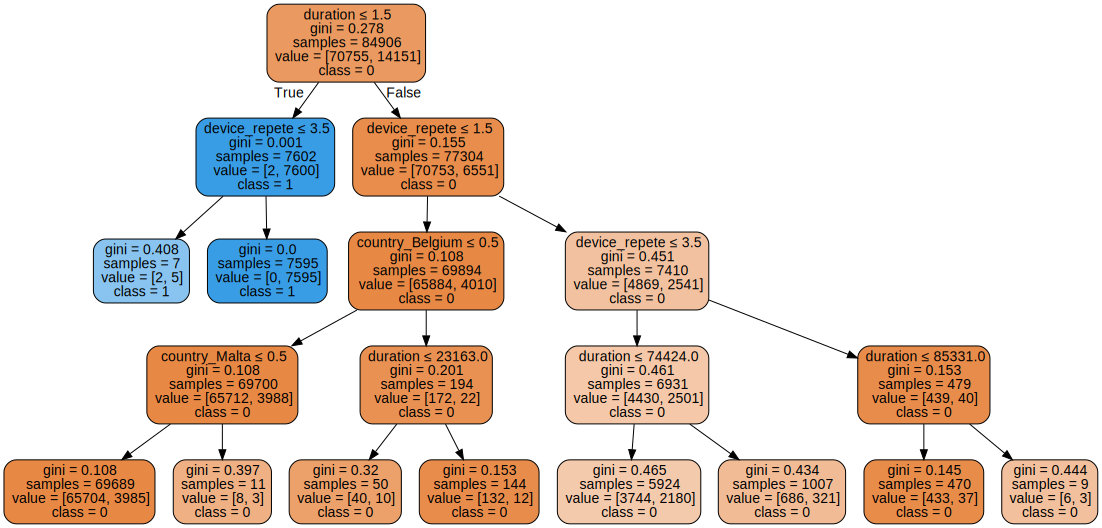

In [311]:

from sklearn import tree
x=[0,6,7,8]
X=d.iloc[:,x]
X = pd.get_dummies(data=X, columns=['country'])
y=[5]
Y=d.iloc[:,y]
clf = tree.DecisionTreeClassifier(criterion = "gini",
            random_state = 100,max_depth=4, min_samples_leaf=5)
clf = clf.fit(X, Y)
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("tree")
feature_names = X.columns
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=feature_names,  
                         class_names=np.array(['0','1']),  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data) 

graph 